# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

df_complete_file = 'df_complete_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    # df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex3/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    # Add the new column with parameter value to IC immune fraction
    df_all['IC_immune_frac'] = 1
    # Define the values to be assigned to samples 1-8 with diff IC proportions
    immune_frac_values = [0.99, 1.01, 0.95, 1.05, 0.9,1.1, 0.8, 1.2]
    # Assign the values to the corresponding samples
    for i, value in enumerate(immune_frac_values, start=1):
        df_all.loc[df_all['sample'] == i, 'IC_immune_frac'] = value

    # Save the dataframe to a feather file
    df_all.to_feather(df_complete_file)

params_list = ['phago_rate_apop', 'phago_rate_nec', 'mac_antinf_secretion_base',
       'attack_duration', 'cd8_migr_speed_base', 'damage_apop_sat',
       'damage_apop_hfm', 'damage_apop_hp', 'dead_debris_sat',
       'dead_debris_hfm', 'dead_debris_hp', 'mac_oxy_proinf_sat',
       'mac_oxy_proinf_hfm', 'mac_oxy_proinf_hp', 'mac_oxy_antinf_hfm',
       'mac_oxy_antinf_hp', 'cd8_antinf_attack_hfm', 'cd8_antinf_attack_hp',
       'cd8_proinf_attack_sat', 'cd8_proinf_attack_hfm',
       'cd8_proinf_attack_hp', 'cd8_antinf_speed_hfm', 'cd8_antinf_speed_hp',
       'cd8_contact_speed_hfm', 'cd8_contact_speed_hp', 'IC_immune_frac']

# 1,264,450 rows = 209 samples * 50 repplicates * 121 time points 

df_complete_ex3.feather already exists. Reading it.


# Define the QoIs: AUC of tumor mean population, distribution of cell distance from the center at the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pool the distances from replicates and calculate the Wassertein distance between tumor and CD8, and tumor and macrophages.


In [2]:
df_qoi_file = 'df_qoi_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
df_summary_file = 'df_summary_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) & os.path.exists(df_qoi_file) ):
    print(f'{df_summary_file} and {df_qoi_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
else:
    print(f'{df_summary_file} or {df_qoi_file} does not exists. Generating it.')
    # Sum tumor_apop and tumor_nec columns into a single column called tumor_dead
    df_all['tumor_dead'] = df_all['tumor_apop'] + df_all['tumor_nec']
    df_all.drop(['tumor_apop', 'tumor_nec'], axis=1, inplace=True)
    # Calculate the AUC for each sample and replicate
    def calculate_auc_wassertein_dist(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_dead','mac_pif_secretion','mac_aif_secretion']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapz(group[col][mask_notna], group['time'][mask_notna])
        wasserstein_values = {}
        subgroup = group[group['time'] == 7200.0] # select the last time point
        # Check if there is no tumor cells at the last time point
        try:
            emp_tumor_cdf = ecdf(subgroup['dist_tumor'].values[0])
            emp_mac_cdf = ecdf(subgroup['dist_mac'].values[0])
            emp_cd8_cdf = ecdf(subgroup['dist_cd8'].values[0])
            wasserstein_values['Wasserstein_dist_Mac'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_mac_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_mac_cdf.cdf.probabilities)
            wasserstein_values['Wasserstein_dist_CD8'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_cd8_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_cd8_cdf.cdf.probabilities)
        except Exception as e:
            print(f'Error calculating Wasserstein distance for sample {subgroup["sample"].values[0]} and replicate {subgroup["replicate"].values[0]}: {e}')
            print(f'Number of tumor cells: {len(subgroup["dist_tumor"].values[0])}, Number of Macrophages: {len(subgroup["dist_mac"].values[0])}, Number of CD8: {len(subgroup["dist_cd8"].values[0])}')
            wasserstein_values['Wasserstein_dist_Mac'] = np.inf
            wasserstein_values['Wasserstein_dist_CD8'] = np.inf
        return pd.Series({**auc_values, **wasserstein_values})

    # Concatenate the dist_tumor_live and dist_tumor_apop and dist_tumor_nec columns into a single column
    df_all['dist_tumor'] = df_all.apply(lambda row: np.concatenate([row['dist_tumor_live'], row['dist_tumor_apop'], row['dist_tumor_nec']]), axis=1)
    df_all.drop(['dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec'], axis=1, inplace=True)
    # Group by 'SampleID' and 'replicate' then calculate AUC and Wassertein distance for each QOI - row dimension of samples x replicates
    df_qoi = df_all.groupby(['sample', 'replicate']).apply(calculate_auc_wassertein_dist).reset_index()
    # Drop outliers: distance = inf
    df_qoi = df_qoi[(df_qoi['Wasserstein_dist_Mac'] != np.inf) & (df_qoi['Wasserstein_dist_CD8'] != np.inf)] # two replicates with no tumor cells: S49R23 and S187R10
    # Add the parameter values to the QoI dataframe
    df_qoi = df_qoi.merge(df_all[['sample', 'replicate'] + params_list], on=['sample', 'replicate'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Calculate the mean and standard deviation of the QoI for each sample
    df_summary = df_qoi.groupby(['sample']).agg({'AUC_tumor_live': ['mean', 'std'], 'AUC_tumor_dead': ['mean', 'std'], 'AUC_mac_pif_secretion': ['mean', 'std'], 'AUC_mac_aif_secretion': ['mean', 'std'], 'Wasserstein_dist_Mac': ['mean', 'std'], 'Wasserstein_dist_CD8': ['mean', 'std']}).reset_index()
    df_summary.columns = ['_'.join(col) if col[1] else col[0] for col in df_summary.columns]
    # Add the parameter values to the summary dataframe
    df_summary = df_summary.merge(df_qoi[['sample'] + params_list], on=['sample'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Save the dataframes to feather files
    df_qoi.to_feather(df_qoi_file)
    df_summary.to_feather(df_summary_file)

print(df_qoi.shape)
print(df_summary.shape)
df_summary

df_summary_ex3.feather and df_qoi_ex3.feather already exists. Reading it.
(10448, 34)
(209, 39)


sample  AUC_tumor_live_mean  AUC_tumor_live_std  AUC_tumor_dead_mean  \
0         0            7240781.4       467114.888516            2715863.4   
1         1            7249698.0       405783.615062            2702886.6   
2         2            7347319.8       472425.988668            2745535.2   
3         3            7345020.6       567694.914924            2748511.2   
4         4            7283129.4       470798.719132            2744153.4   
..      ...                  ...                 ...                  ...   
204     204            7324340.4       457323.773839            2730448.2   
205     205            7279527.6       535063.173053            2733967.8   
206     206            7247568.0       446052.755743            2740980.0   
207     207            7256892.6       537130.756721            2732553.6   
208     208            7238346.0       398539.353364            2729038.2   

     AUC_tumor_dead_std  AUC_mac_pif_secretion_mean  \
0         133837.825525                50792.172022   
1         147884.318532                50593.103208   
2         135017.869070                50492.996165   
3         122516.406076                50449.845860   
4         124892.824676                50739.563335   
..                  ...                         ...   
204       131514.086678                50241.556921   
205       122170.178420                50600.759529   
206       136449.764876                50562.158334   
207       140858.930295                50663.487954   
208       123546.269242                50797.820779   

     AUC_mac_pif_secretion_std  AUC_mac_aif_secretion_mean  \
0                  2976.980188                21207.827978   
1                  2687.662137                21406.896792   
2                  3155.274479                21507.003835   
3                  3763.386308                21550.154140   
4                  3212.109798                21260.436665   
..                         ...                         ...   
204                3025.722748                21758.443079   
205                3476.499593                21399.240471   
206                3053.966315                21437.841666   
207                3544.769234                21336.512046   
208                2630.175981                21202.179221   

     AUC_mac_aif_secretion_std  Wasserstein_dist_Mac_mean  ...  \
0                  2976.980188                  85.858287  ...   
1                  2687.662137                  81.732291  ...   
2                  3155.274479                  72.342017  ...   
3                  3763.386308                  71.375166  ...   
4                  3212.109798                  83.117825  ...   
..                         ...                        ...  ...   
204                3025.722748                  72.766223  ...   
205                3476.499593                  82.103207  ...   
206                3053.966315                  79.336540  ...   
207                3544.769234                  78.863829  ...   
208                2630.175981                  78.427483  ...   

     cd8_antinf_attack_hfm  cd8_antinf_attack_hp  cd8_proinf_attack_sat  \
0                      0.5                   8.0                    1.0   
1                      0.5                   8.0                    1.0   
2                      0.5                   8.0                    1.0   
3                      0.5                   8.0                    1.0   
4                      0.5                   8.0                    1.0   
..                     ...                   ...                    ...   
204                    0.5                   8.0                    1.0   
205                    0.5                   8.0                    1.0   
206                    0.5                   8.0                    1.0   
207                    0.5                   8.0                    1.0   
208                    0.5                   8.0        

Sample with reference parameters:  [1.0e-01 1.7e-02 1.0e+01 1.5e+01 1.0e+00 2.3e-02 4.5e+01 1.6e+01 1.7e-02
 1.0e-01 1.0e+01 1.0e+01 1.2e+01 1.6e+01 1.2e+01 1.6e+01 5.0e-01 8.0e+00
 1.0e+00 5.0e-01 8.0e+00 5.0e-01 8.0e+00 5.0e-01 8.0e+00 1.0e+00]


/opt/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


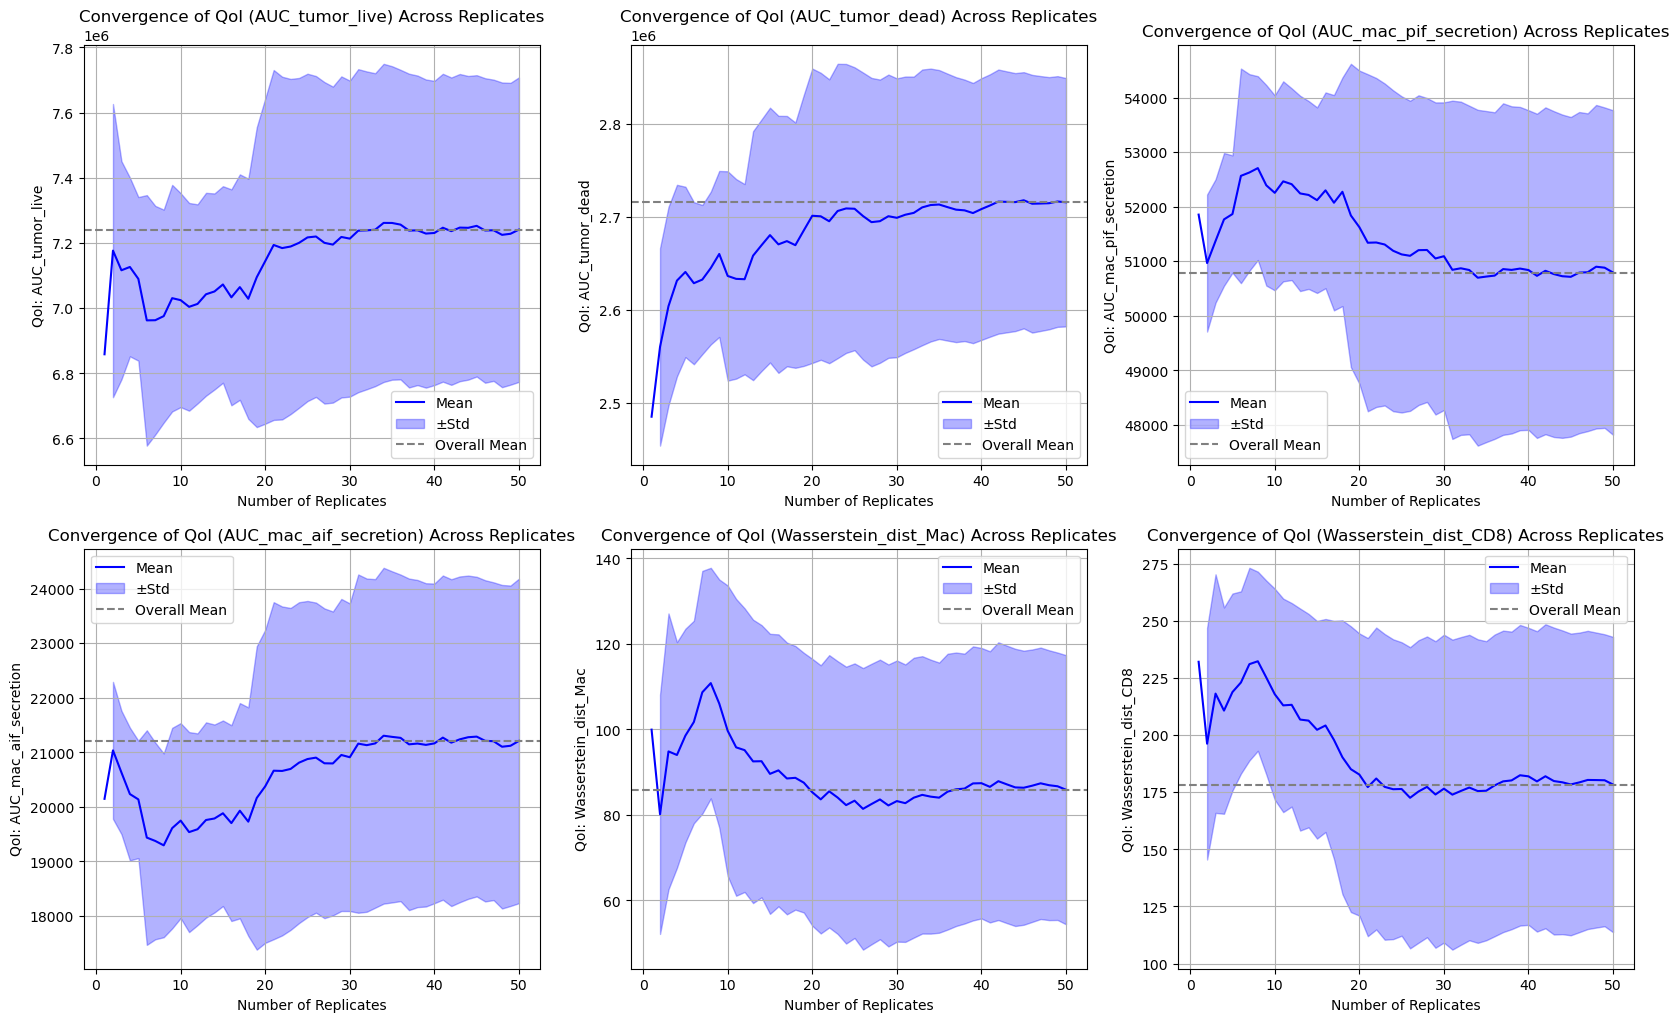

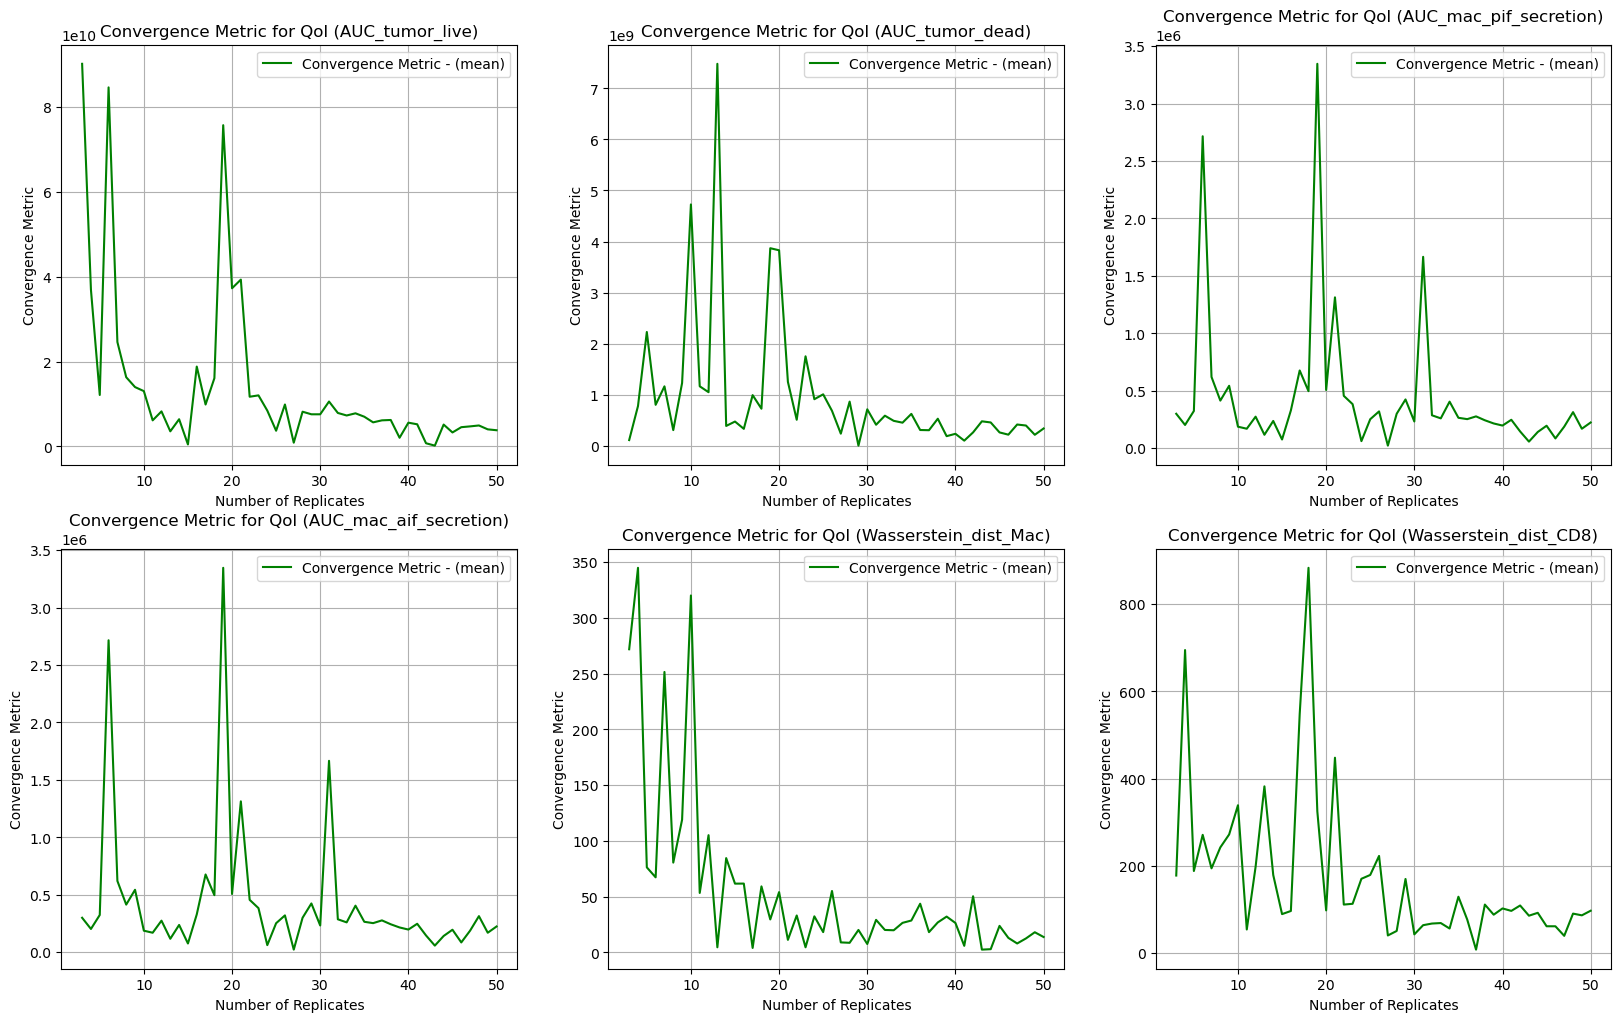

In [3]:
import matplotlib.pyplot as plt
from convergence_analysis import mean_variance_convergence, test_convergence, bootstrap_convergence

sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)
QoIs_list = ['AUC_tumor_live', 'AUC_tumor_dead', 'AUC_mac_pif_secretion', 'AUC_mac_aif_secretion', 'Wasserstein_dist_Mac', 'Wasserstein_dist_CD8']

figure1, axes = plt.subplots(2, 3, figsize=(20, 12))
figure2, axes2 = plt.subplots(2, 3, figsize=(20, 12))
for qoi, ax, ax2 in zip(QoIs_list, axes.flatten(), axes2.flatten()):
    data = df_qoi.loc[ df_qoi['sample'] == sample_ref][qoi].values
    # Calculate running mean and variance for the QoI
    running_means, running_var = mean_variance_convergence(data)
    running_stds = np.sqrt(running_var)
    # Test convergence using the auto-selected method
    window_size = 5
    convergence_metric, method_selected = test_convergence(data, method='mean', window_size=window_size)
    # Test convergence using bootstrapping
    bootstrap_metric = bootstrap_convergence(data)
    # Plot the running mean and standard deviation
    x = np.arange(1, len(data) + 1)
    ax.plot(x, running_means, label='Mean', color='b')
    ax.fill_between(x, running_means - running_stds, running_means + running_stds, alpha=0.3, label='±Std', color='b')
    ax.axhline(np.mean(data), color='gray', linestyle='--', label='Overall Mean')
    ax.set_xlabel('Number of Replicates')
    ax.set_ylabel(f'QoI: {qoi}')
    ax.set_title(f'Convergence of QoI ({qoi}) Across Replicates')
    ax.grid()
    ax.legend()
    # Plot the convergence metric
    ax2.plot(x[1:], convergence_metric, label=f'Convergence Metric - ({method_selected})', color='green')
    # ax2_y2 = ax2.twinx()
    # ax2_y2.plot(x, bootstrap_metric, label='Bootstrapped Variability', color='red')
    # ax2_y2.set_ylabel('Bootstrapped Variability')
    ax2.set(xlabel='Number of Replicates', ylabel='Convergence Metric',title=f'Convergence Metric for QoI ({qoi})')
    ax2.grid()
    ax2.legend()
plt.show()

# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Relative sensitivity (Elasticity -  For every $1\%$ change in $\theta_i$, the output changes by $\bar{S}_{\theta_i} \times 1\%$:

$$\bar{S}_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{\theta_i - \theta^\star}\cdot \dfrac{\theta^\star}{f(\theta^\star)}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [4]:
# Calculate the sensitivity index
QoIs_list = [qoi+'_mean' for qoi in QoIs_list]
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append(params_list[0]); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values
    relative_change_qois = absolute_change_qois / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    absolute_change_params = sensitivity_analysis_dic['SA_delta'] * df_summary.iloc[sample_ref][ sensitivity_analysis_dic['SA_parameter'] ].to_numpy()
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_analysis_dic['SA_delta']
        parameter_name = sensitivity_analysis_dic['SA_parameter']
        sensitivity_analysis_dic[f'Abs_SI_{qoi}'] = absolute_change_qois.to_numpy()[:,id_qoi]/absolute_change_params
    
    # Change the delta of reference value to 0 and label it as reference
    sensitivity_analysis_dic['SA_delta'][0] = 0
    sensitivity_analysis_dic['SA_parameter'][0] = 'Reference'
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: {sample_lowest_qoi} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and {sample_highest_qoi} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: {sample_lowest_si} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and {sample_highest_si} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

QoI: AUC_tumor_live_mean
	 lowest and highest QoI: 48.0 (cd8_migr_speed_base) and 112.0 (mac_oxy_proinf_hfm)
	 lowest and highest SI: 81 (dead_debris_hfm) and 18 (phago_rate_nec)

QoI: AUC_tumor_dead_mean
	 lowest and highest QoI: 111.0 (mac_oxy_proinf_hfm) and 112.0 (mac_oxy_proinf_hfm)
	 lowest and highest SI: 41 (cd8_migr_speed_base) and 106 (mac_oxy_proinf_hfm)

QoI: AUC_mac_pif_secretion_mean
	 lowest and highest QoI: 112.0 (mac_oxy_proinf_hfm) and 111.0 (mac_oxy_proinf_hfm)
	 lowest and highest SI: 108 (mac_oxy_proinf_hfm) and 41 (cd8_migr_speed_base)

QoI: AUC_mac_aif_secretion_mean
	 lowest and highest QoI: 127.0 (mac_oxy_antinf_hfm) and 128.0 (mac_oxy_antinf_hfm)
	 lowest and highest SI: 41 (cd8_migr_speed_base) and 122 (mac_oxy_antinf_hfm)

QoI: Wasserstein_dist_Mac_mean
	 lowest and highest QoI: 128.0 (mac_oxy_antinf_hfm) and 111.0 (mac_oxy_proinf_hfm)
	 lowest and highest SI: 106 (mac_oxy_proinf_hfm) and 9 (phago_rate_apop)

QoI: Wasserstein_dist_CD8_mean
	 lowest and highe

sample          SA_parameter  SA_delta  SI_AUC_tumor_live_mean  \
0         0             Reference      0.00                0.000000   
1         1        IC_immune_frac     -0.01               -0.123144   
2         2        IC_immune_frac      0.01                1.471366   
3         3        IC_immune_frac     -0.05               -0.287923   
4         4        IC_immune_frac      0.05                0.116971   
..      ...                   ...       ...                     ...   
204     204  cd8_contact_speed_hp      0.05                0.230801   
205     205  cd8_contact_speed_hp     -0.10               -0.053511   
206     206  cd8_contact_speed_hp      0.10                0.009373   
207     207  cd8_contact_speed_hp     -0.20               -0.011125   
208     208  cd8_contact_speed_hp      0.20               -0.001682   

     Abs_SI_AUC_tumor_live_mean  SI_AUC_tumor_dead_mean  \
0                  0.000000e+00                0.000000   
1                 -8.916600e+05                0.477815   
2                  1.065384e+07                1.092537   
3                 -2.084784e+06               -0.240423   
4                  8.469600e+05                0.208332   
..                          ...                     ...   
204                2.088975e+05                0.107405   
205               -4.843275e+04               -0.066662   
206                8.483250e+03                0.092481   
207               -1.006950e+04               -0.030727   
208               -1.522125e+03                0.024255   

     Abs_SI_AUC_tumor_dead_mean  SI_AUC_mac_pif_secretion_mean  \
0                         0.000                       0.000000   
1                   1297680.000                       0.391928   
2                   2967180.000                      -0.589020   
3                   -652956.000                       0.134795   
4                    565800.000                      -0.020715   
..                          ...                            ...   
204                   36462.000                      -0.216811   
205                  -22630.500                       0.037685   
206                   31395.750                      -0.045285   
207                  -10431.375                       0.012668   
208                    8234.250                       0.000556   

     Abs_SI_AUC_mac_pif_secretion_mean  SI_AUC_mac_aif_secretion_mean  \
0                             0.000000                       0.000000   
1                         19906.881374                      -0.938657   
2                        -29917.585730                       1.410686   
3                          6846.523248                      -0.322830   
4                         -1052.173745                       0.049613   
..                                 ...                            ...   
204                       -1376.537752                       0.519256   
205                         239.265616                      -0.090256   
206                        -287.517110                       0.108457   
207                          80.427543                      -0.030339   
208                           3.530473                      -0.001332   

     Abs_SI_AUC_mac_aif_secretion_mean  SI_Wasserstein_dist_Mac_mean  \
0                             0.000000                      0.000000   
1                        -19906.881374                      4.805589   
2                         29917.585730                    -15.742534   
3                         -6846.523248                      3.373727   
4                          1052.173745                     -0.638369   
..                                 ...                           ...   
204                        1376.537752                     -3.049691   
205                        -239.265616                      0.437358   
206                         287.517110                     -0.759594   
207                         -80.427543               

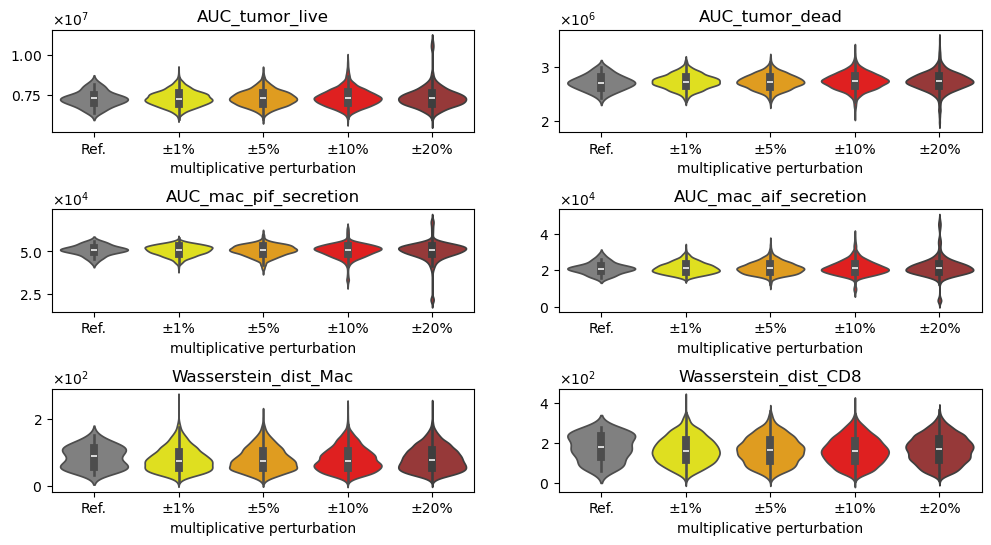

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    # Plot a box plot for each QoI (x axis: SA_delta, y axis: QoI value)
    # ax.boxplot([df_all[df_summary['sample'] == sample][qoi].values for sample in [sample_ref, *samples_deltap1, *samples_deltam1, *samples_deltap5, *samples_deltam5, *samples_deltap10, *samples_deltam10, *samples_deltap20, *samples_deltam20]], showfliers=False)
    for delta, color in zip([0.0, 0.01, 0.05, 0.1, 0.2], 
                            ['gray', 'yellow', 'orange', 'red', 'brown']):
        samples = df_SA[ (df_SA['SA_delta'] == delta) | (df_SA['SA_delta'] == -1*delta) ]['sample'].values
        values = df_qoi[df_qoi['sample'].isin(samples)][qoi[:-5]].values
        sns.violinplot(x=[delta*100]*len(values), y=values, ax=ax, color=color)
    
    # change the x ticks label adding +- sign
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['Ref.', '±1%', '±5%', '±10%', '±20%'])
    ax.set_title(qoi[:-5])
    ax.set_xlabel('multiplicative perturbation')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
# plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_63048/1714118094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA["SA_delta"] = df_SA["SA_delta"] * 100


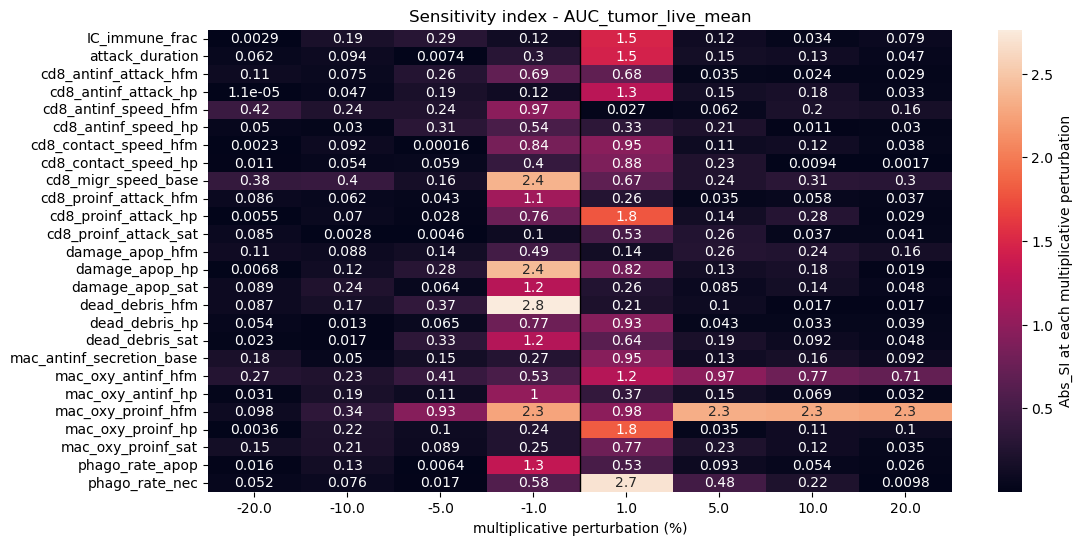

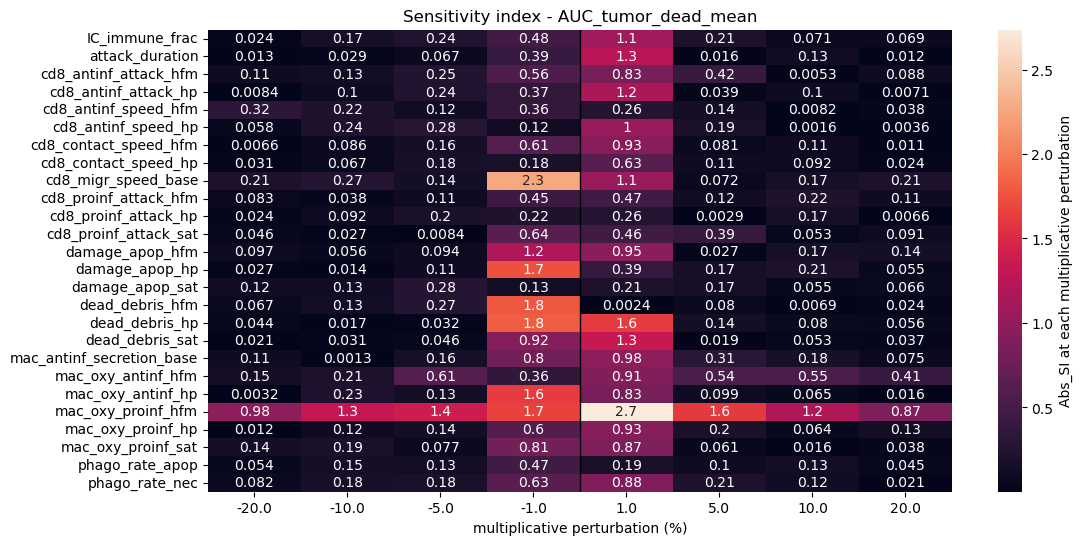

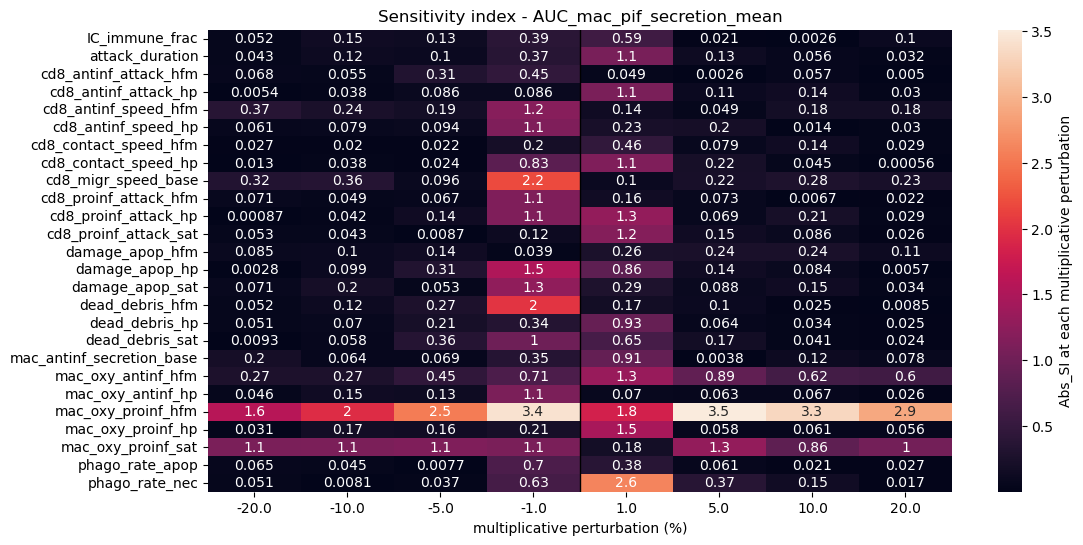

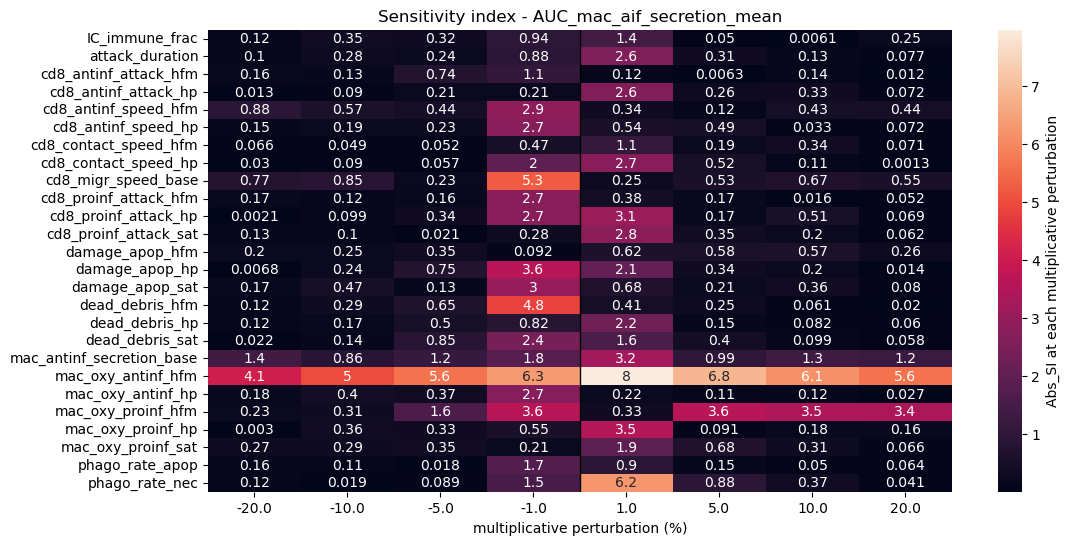

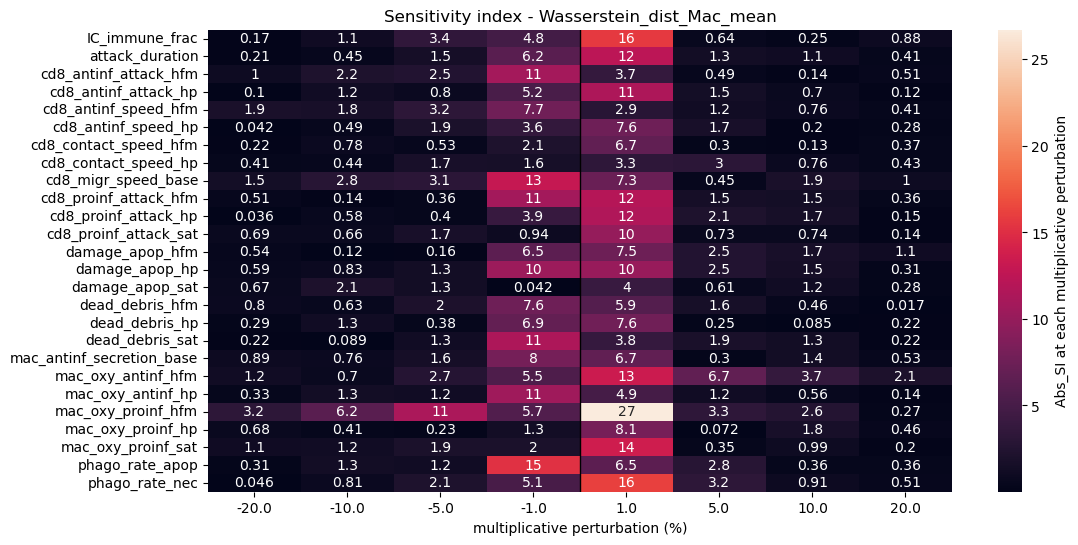

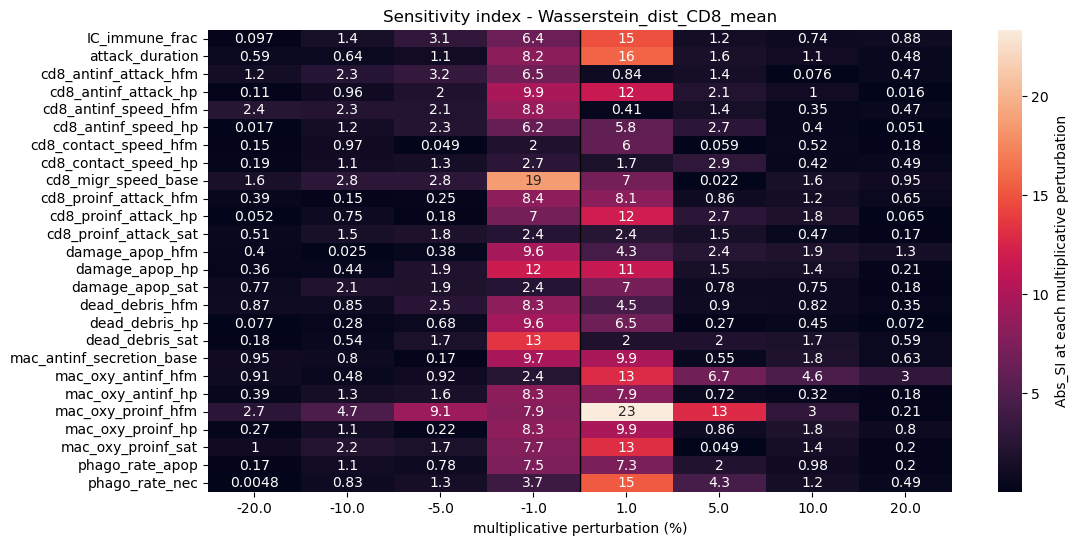

In [6]:
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Convert the multiplicative perturbation to percentage
df_SA["SA_delta"] = df_SA["SA_delta"] * 100
plot = 'Abs_SI' # plot_options =  ["SI", "Abs_SI", 'Rank']
# Plot the parameter rank according to the relatice sensitivity index as heatmap with the parameters vs delta and color as the rank
for qoi in QoIs_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    if plot == 'SI':
        # pivot the dataframe to have the parameter as index, delta as columns and sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    if plot == 'Abs_SI':
        # pivot the dataframe to have the parameter as index, delta as columns and absolute sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    if plot == 'Rank':
        df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
        # rank of each parameter for each multiplicative perturbation ( 1 - highest sensitivity, 2 - second highest sensitivity, etc)
        df_SA_pivot_plot = df_SA_pivot.rank(axis=0, method='min', ascending=False)

    # print(df_SA_pivot.head(),'\n')
    # print(df_SA_pivot_rank.head(),'\n')
    # 
    sns.heatmap(df_SA_pivot_plot, cmap='rocket', annot=True,ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_label(f'{plot} at each multiplicative perturbation')
    # draw a line to separate the positive and negative values
    ax.axvline(4, color='black', lw=1)
    ax.set(title = f'Sensitivity index - {qoi}', xlabel='multiplicative perturbation (%)', ylabel=None)
plt.show()

# Calculate the Normalized SI in each multiplicative perturbation
$$ Normalize SI_{i,j} = \frac{SI_{i,j}}{\max SI_{.,j}},$$

where $S_{i,j}$ is the sensitivity index in each parameter $i$ and multiplicative pertubation $j$


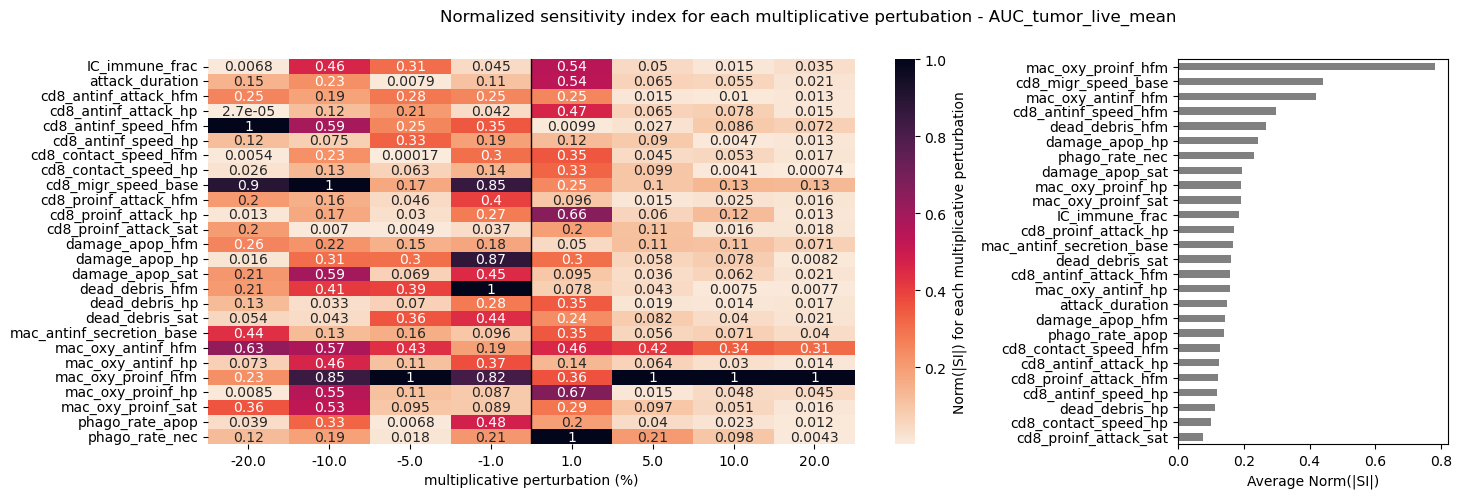

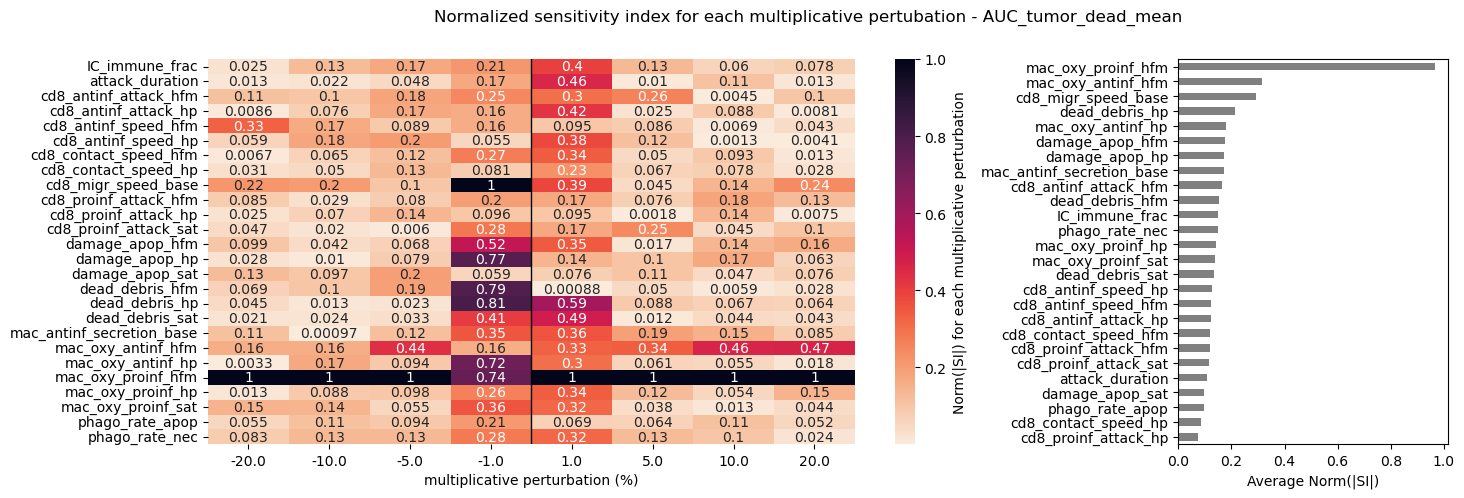

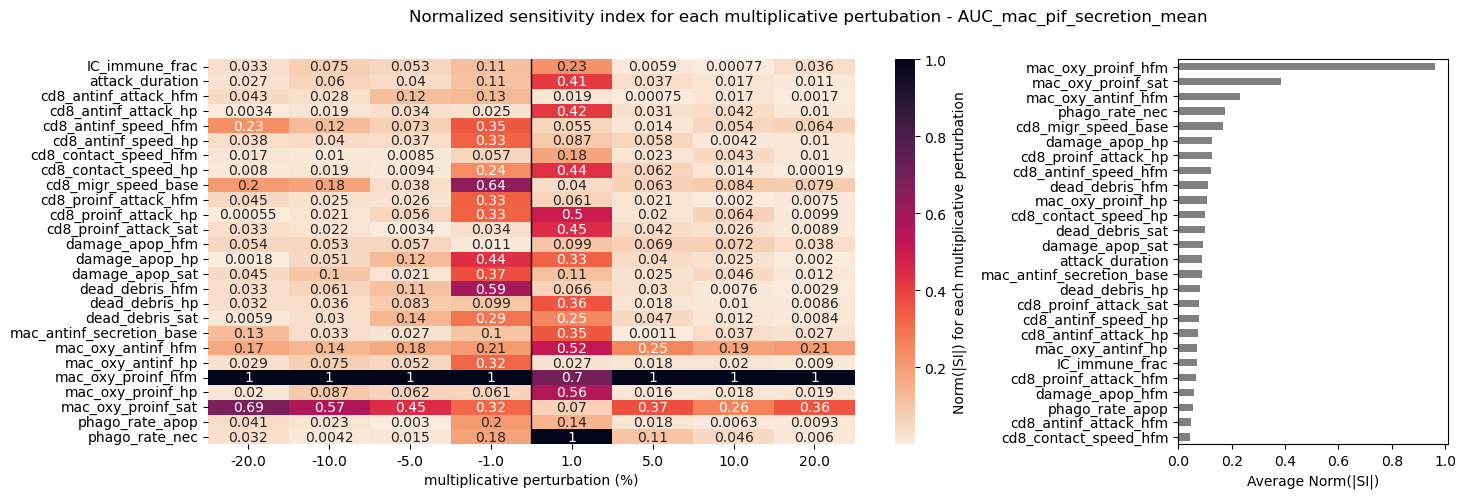

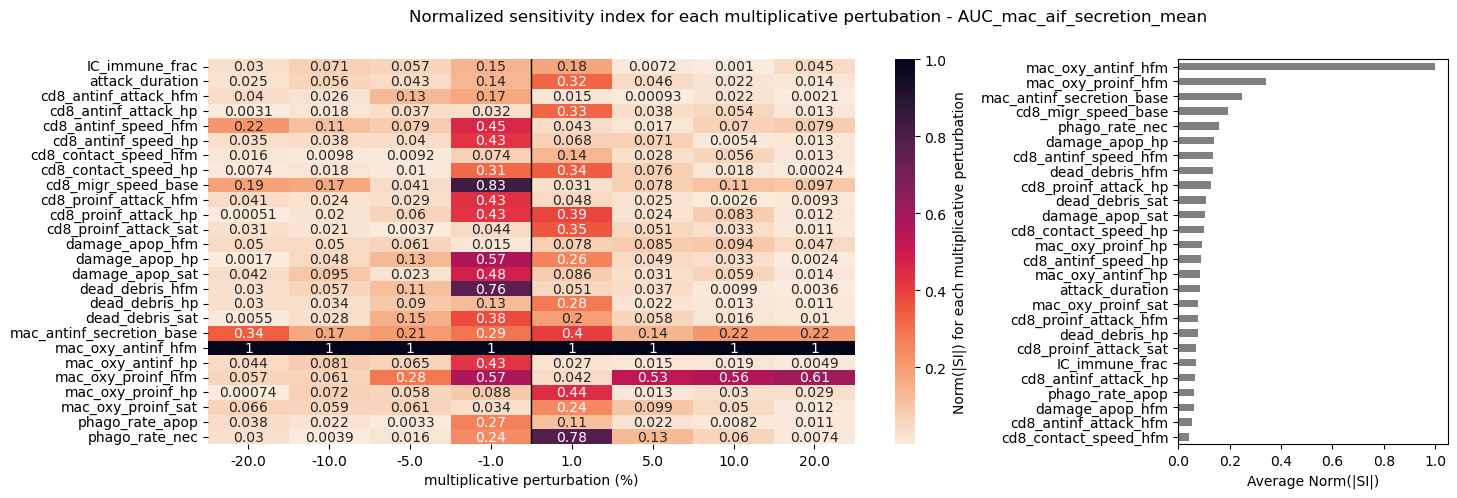

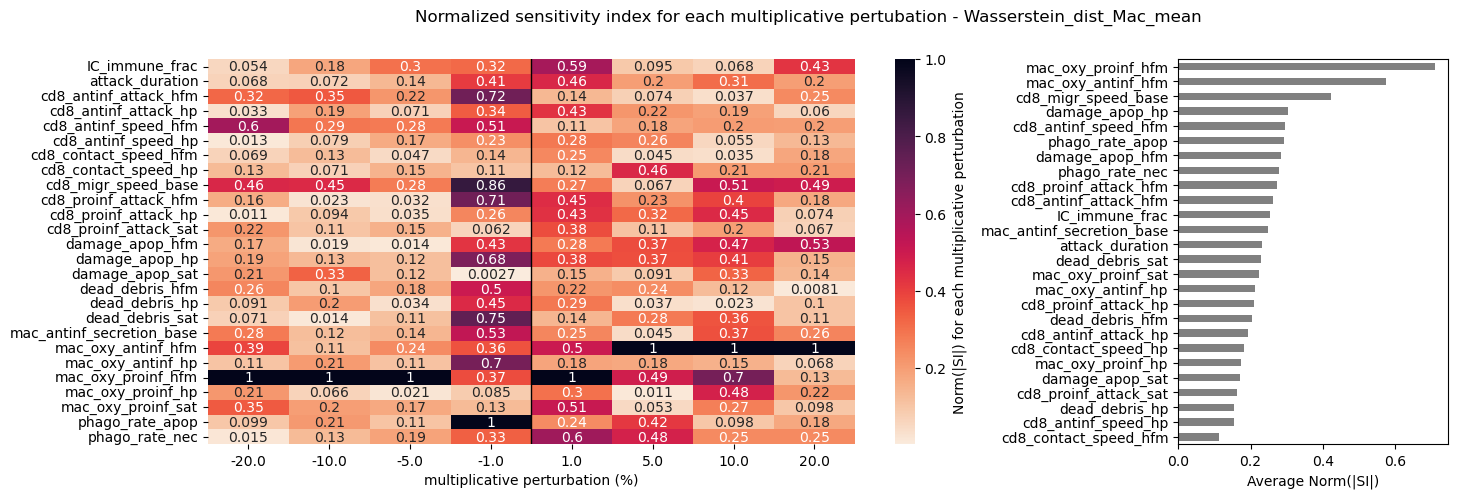

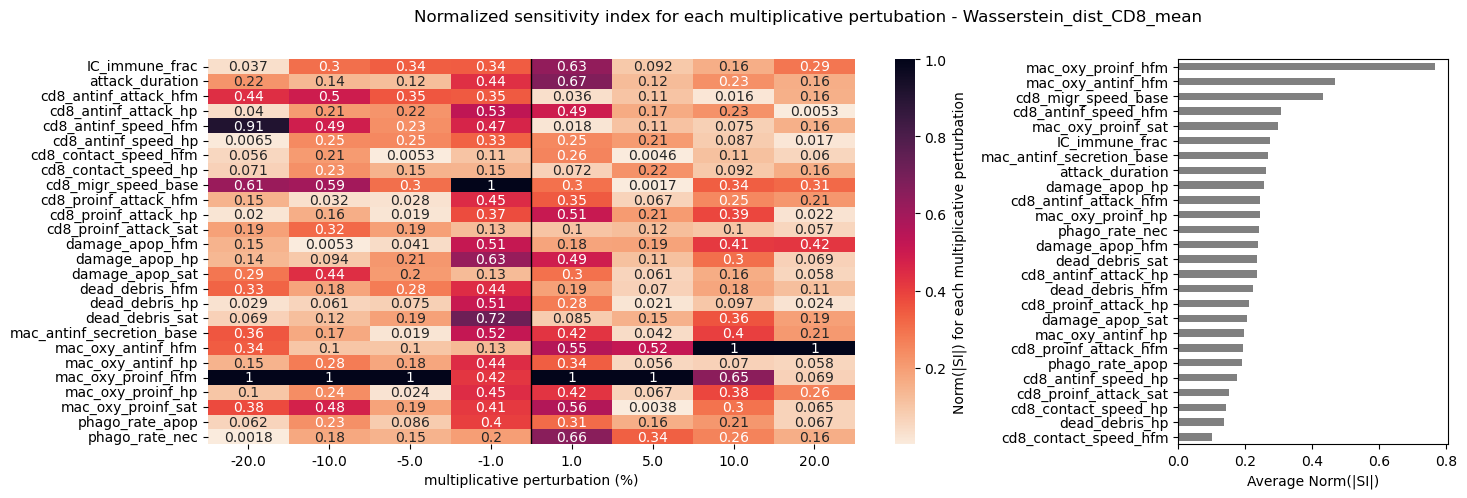

In [7]:
for qoi in QoIs_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Normalized sensitivity index for each multiplicative pertubation - {qoi}')
    # Round the values to 2 decimal places
    # df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
    df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    # df of the rank of each parameter for each multiplicative perturbation
    # df_SA_pivot_rank = df_SA_pivot.rank(axis=0, method='min', ascending=False)
    # convert the rank to rank sensitivity index
    # df_SA_pivot_RSI = (df_SA_pivot_rank.shape[0] - df_SA_pivot_rank) / (df_SA_pivot_rank.shape[0] - 1)
    df_SA_pivot_RSI = df_SA_pivot / df_SA_pivot.max()
    sns.heatmap(df_SA_pivot_RSI, cmap='rocket_r', annot=True,ax=ax1)
    cbar = ax1.collections[0].colorbar
    cbar.set_label('Norm(|SI|) for each multiplicative perturbation')
    ax1.set(xlabel='multiplicative perturbation (%)', ylabel=None)
    # draw a line to separate the positive and negative values
    ax1.axvline(4, color='black', lw=1)
    # Average the RSI across all multiplicative perturbations
    df_rsi_mean = df_SA_pivot_RSI.mean(axis=1)
    df_rsi_mean = df_rsi_mean.sort_values(ascending=True)
    df_rsi_mean.plot(kind='barh', ax=ax2, color='gray')
    ax2.set(xlabel='Average Norm(|SI|)', ylabel=None)

 

# Interpretation of results

The local SA does not show clear interpretation, the parameters importance rank changes drastically according the multiplicative perturbation. This coudl be related to the nonlinear behavior: the sensitivity of the output can change depending on the magnitude of the parameters, local vs global: different parameters might dominate at different scales, interactions between the parameters might become more pronounced.
